In [11]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix, pivot_resdf
)
from bold_dementia.utils.iterables import unique
import networkx as nx

ATLAS = "gillig-regions"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)


In [12]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf_pv = pivot_resdf(resdf, alpha=ALPHA)

In [13]:
minidf = resdf.loc[:, ["node_a", "node_b", "thresholded_beta"]]
minidf = minidf.rename({"thresholded_beta": "weight"}, axis=1)

In [14]:
minidf[minidf.weight != 0]

,node_a,node_b,weight
0,RSN01,RSN01,-0.023240
46,RSN02,RSN10,0.011074
65,RSN11,RSN11,-0.018358
154,RSN02,RSN18,-0.013549
218,RSN09,RSN21,-0.011936
277,RSN02,RSN24,0.011663
280,RSN05,RSN24,-0.009389
281,RSN06,RSN24,-0.011674
282,RSN07,RSN24,-0.013495
354,RSN04,RSN27,0.010884


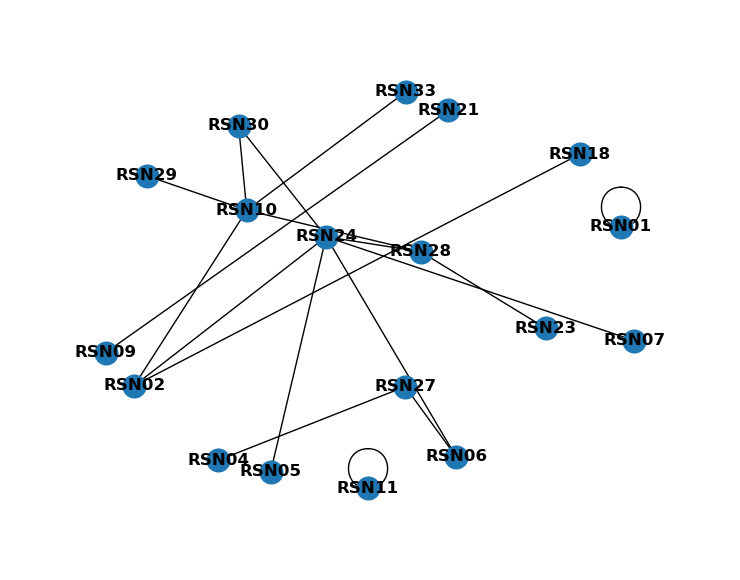

In [15]:
G = nx.from_pandas_edgelist(
    minidf[minidf.weight != 0],
    source="node_a",
    target="node_b",
    edge_attr="weight"
)

nx.draw(G, with_labels=True, font_weight='bold')

plt.show()



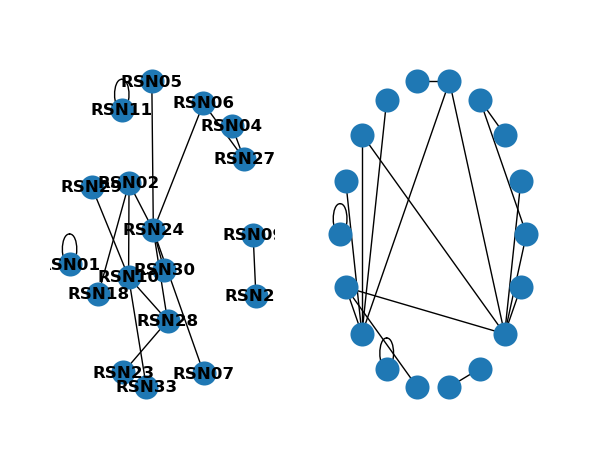

In [16]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')

subax2 = plt.subplot(122)

nx.draw_shell(G)

In [17]:
matrix_df = resdf_pv["thresholded_beta"]
matrix_df.fillna(value=0, inplace=True)
import math
labels = atlas.labels_

links = []
msk = []

for source, row in matrix_df.iterrows():
    for target_rsn, val in row.items():
        if math.isclose(val, 0):
            continue
        elif val > 0:
            colour = "red"
        elif val < 0:
            colour = "blue"
            
        offset = abs((100 * val))
        assert offset < 10
        print(source, target_rsn, val, offset)
        if source != target_rsn:
            links.append(
                (
                    (source, 5 - offset / 2, 5 + offset / 2),
                    (target_rsn, 5 - offset / 2, 5 + offset / 2),
                    colour
                )
            )
        else:
            links.append(
                (
                    (source, 0, offset),
                    (target_rsn, 10 - offset, 10),
                    colour
                )
            )
            

RSN01 RSN01 -0.0232401076486625 2.3240107648662502
RSN02 RSN10 0.0110737362235186 1.10737362235186
RSN02 RSN18 -0.0135489809281059 1.35489809281059
RSN02 RSN24 0.011663106209997 1.1663106209997
RSN04 RSN27 0.0108844054680438 1.08844054680438
RSN05 RSN24 -0.0093892829496091 0.93892829496091
RSN06 RSN24 -0.0116744176228724 1.1674417622872402
RSN06 RSN27 0.011657327852661 1.1657327852661
RSN07 RSN24 -0.0134946325755313 1.34946325755313
RSN09 RSN21 -0.0119355656484315 1.19355656484315
RSN10 RSN28 0.0110969321355467 1.10969321355467
RSN10 RSN29 0.0116929891729873 1.16929891729873
RSN10 RSN30 0.0135021234910392 1.35021234910392
RSN10 RSN33 0.0113849946200925 1.1384994620092501
RSN11 RSN11 -0.0183584179789026 1.83584179789026
RSN23 RSN28 0.0123330725144143 1.23330725144143
RSN24 RSN28 0.0091409693707617 0.91409693707617
RSN24 RSN30 0.0146787974737926 1.46787974737926


/tmp/ipykernel_1754350/1320699398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df.fillna(value=0, inplace=True)


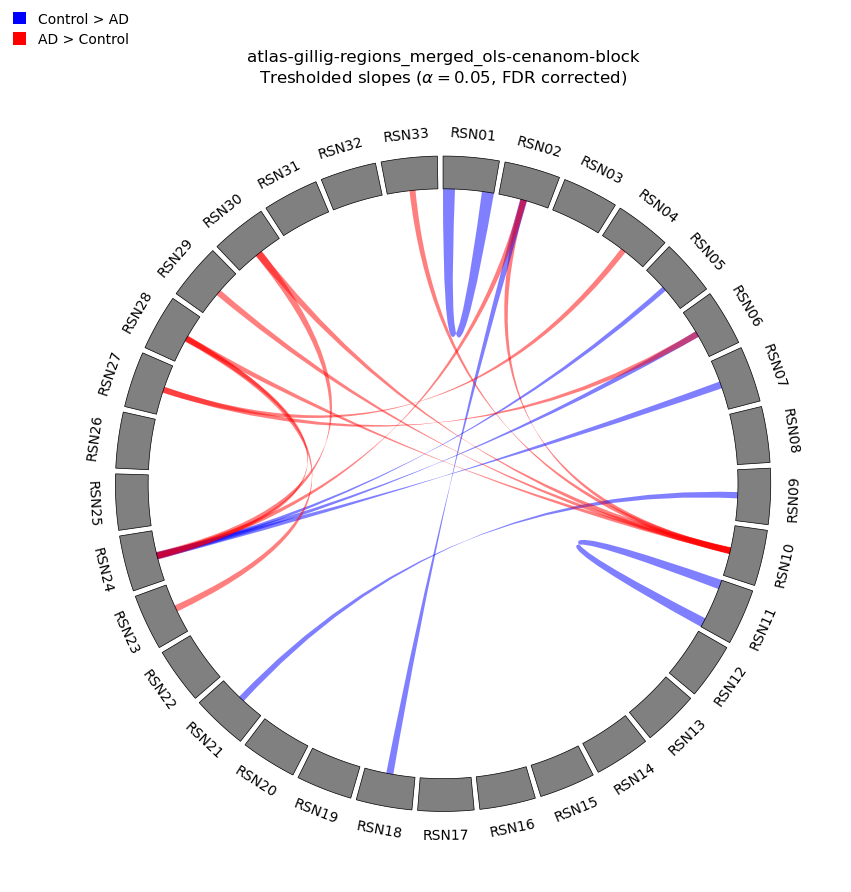

In [18]:
from pycirclize import Circos
import matplotlib.patches as mpatches

networks = matrix_df.columns.to_list()
sectors = {n: 10 for n in networks}
circos = Circos(sectors, space=1)

cmap="gray",
link_cmap=links,
ticks_kws={"label_size": 2},
r_lim=(90, 100)
# TODO Name to color
for sector in circos.sectors:
    # Plot label, outer track axis & xticks
    sector.text(sector.name)
    outer_track = sector.add_track(r_lim)
    color = "gray"
    outer_track.axis(fc=color)


# Plot links
for link in links:
    circos.link(*link[:2], color=link[2])
#circos.link(('RSN01', 1, 3), ('RSN01', 6, 9), color='blue')

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

fig = circos.plotfig()
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)
fig.show()

In [19]:
links

[(('RSN01', 0, 2.3240107648662502), ('RSN01', 7.67598923513375, 10), 'blue'),
 (('RSN02', 4.44631318882407, 5.55368681117593),
  ('RSN10', 4.44631318882407, 5.55368681117593),
  'red'),
 (('RSN02', 4.322550953594705, 5.677449046405295),
  ('RSN18', 4.322550953594705, 5.677449046405295),
  'blue'),
 (('RSN02', 4.41684468950015, 5.58315531049985),
  ('RSN24', 4.41684468950015, 5.58315531049985),
  'red'),
 (('RSN04', 4.45577972659781, 5.54422027340219),
  ('RSN27', 4.45577972659781, 5.54422027340219),
  'red'),
 (('RSN05', 4.530535852519545, 5.469464147480455),
  ('RSN24', 4.530535852519545, 5.469464147480455),
  'blue'),
 (('RSN06', 4.41627911885638, 5.58372088114362),
  ('RSN24', 4.41627911885638, 5.58372088114362),
  'blue'),
 (('RSN06', 4.41713360736695, 5.58286639263305),
  ('RSN27', 4.41713360736695, 5.58286639263305),
  'red'),
 (('RSN07', 4.325268371223435, 5.674731628776565),
  ('RSN24', 4.325268371223435, 5.674731628776565),
  'blue'),
 (('RSN09', 4.403221717578425, 5.596778282

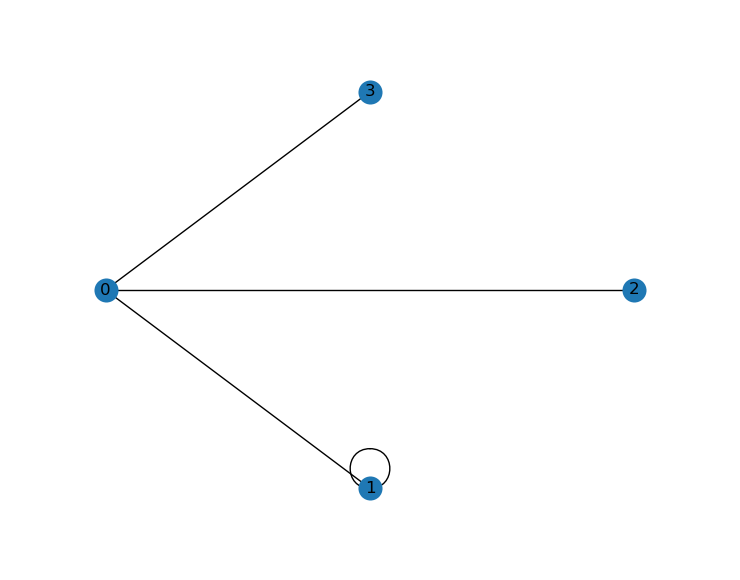

In [20]:
adjacency_dict = {0: (1, 2, 3), 1: (0, 1)}

H = nx.Graph(adjacency_dict)  # create a Graph dict mapping nodes to nbrs


nx.draw_shell(H, with_labels=True)